In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from __future__ import absolute_import, division, print_function
from sys import getsizeof

# Import TensorFlow >= 1.10 and enable eager execution
import tensorflow as tf
tf.enable_eager_execution()

import librosa
import os
import time
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
import pandas as pd
import librosa
import simpleaudio as sa
import math
from IPython import display
import warnings

import matplotlib.colors as colors
from scipy.io import wavfile
import librosa.display
import numpy as np
from numpy.linalg import pinv, inv, solve, lstsq
import simpleaudio as sa

C:\Users\1002983\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Converting into spectrograms
# Spectrograms are stored as spectrograms.tfrecord
nsynth = tf.data.TFRecordDataset("C:/Users/1002983/Documents/machine-learning-tone-generation/project/nsynth-test.tfrecord")
#nsynth = tf.data.TFRecordDataset("/Users/asianzhang/Documents/GitHub/machine-learning-tone-generation/project/nsynth-test.tfrecord")
i = 1
numTrue = 0
read_features = {
    'note': tf.FixedLenFeature([], dtype=tf.int64),
    'note_str': tf.FixedLenFeature([], dtype=tf.string),
    'instrument': tf.FixedLenFeature([], dtype=tf.int64),
    'instrument_str': tf.FixedLenFeature([], dtype=tf.string),
    'pitch': tf.FixedLenFeature([], dtype=tf.int64),
    'velocity': tf.FixedLenFeature([], dtype=tf.int64),
    'sample_rate': tf.FixedLenFeature([], dtype=tf.int64),
    'audio': tf.VarLenFeature(dtype=float),
    'instrument_family': tf.FixedLenFeature([], dtype=tf.int64),
    'instrument_family_str': tf.FixedLenFeature([], dtype=tf.string),
    'instrument_source': tf.FixedLenFeature([], dtype=tf.int64),
    'instrument_source_str': tf.FixedLenFeature([], dtype=tf.string)
}
i = 0
j = 0
for b in nsynth:
    i += 1
    data = tf.parse_single_example(serialized=b, features=read_features)
    print(i, end='\r')
    if(data['instrument_source'].numpy()==0 and data['instrument_family'].numpy()==7):
        if(j < 50):
            j += 1
            continue
        audio = data['audio'].values.numpy()*15000
        audio = np.array(audio)
        spectrogram = librosa.stft(audio, 2048)

        magnitudes = np.log(np.abs(spectrogram) + 1.2664166e-14).reshape(1025, 126, 1)
        phases = np.angle(spectrogram).reshape(1025, 126, 1)
        phases = phases / (math.pi)
        magnitudes = 2*(magnitudes+32)/(16+32)-1
        spec = np.concatenate([magnitudes, phases], 2)
        print(data['instrument_str'])
        break

print("\nDone")

tf.Tensor(b'reed_acoustic_037', shape=(), dtype=string)

Done


In [3]:
def audioFigs(filename, figure_name, audio, sr, seconds_interval=1, scaling=True, playBack=False, seconds=None):
    if(len(audio.shape) == 2): 
        audio = audio[:, 0]
    if(seconds != None):
        audio = audio[0:int(seconds*sr)]
    if(scaling):
        audio = audio / np.amax([np.amax(audio), -1*np.amin(audio)]) * 15000
    spectrogram = librosa.stft(audio, 2048)
    magnitudes = np.log(np.abs(spectrogram) + 1.2664166e-14)
    phases = np.angle(spectrogram) / math.pi
    if(sr==16000):
        num_ticks = 4
    elif(sr==44100):
        num_ticks = 5
    else:
        warnings.warn("Sample rate of {} unfamiliar, please add test condition".format(sr))
        num_ticks = 4

    plt.figure(0)
    plt.plot(np.arange(0, audio.size/sr, 1/sr)[:audio.size], audio)
    plt.xlabel("Time (s)")
    plt.ylabel("Samples")
    if(figure_name is None):
        plt.title("Raw audio".format(figure_name))
    else:
        plt.title("{}: Raw audio".format(figure_name))
    plt.ylim(-15000, 15000)
    plt.xlim(0, audio.size/sr)
    plt.yticks(np.arange(-15000, 15001, 5000))
    plt.savefig("{}-raw.png".format(filename), bbox_inches='tight')
    
    basis = librosa.fft_frequencies(sr=sr, n_fft=(2 * (magnitudes.shape[0]-1)))
    fmax = basis[-1]
    basis -= 0.5 * (basis[1] - basis[0])
    basis = np.append(np.maximum(0, basis), [fmax])
    fmax = np.amax(basis)
    
    plt.figure(1)
    plt.imshow(magnitudes, cmap="magma", origin="lower", aspect="auto", extent=[0, magnitudes.shape[1], 0, magnitudes.shape[0]])
    if(figure_name is None):
        plt.title("Spectrogram (magnitudes)".format(figure_name))
    else:
        plt.title("{}: Spectrogram (magnitudes)".format(figure_name))
    plt.yticks(np.arange(0, magnitudes.shape[0]+1, magnitudes.shape[0]/num_ticks), np.arange(0, int(fmax+1), int(fmax/num_ticks)))
    plt.xticks(np.arange(0, magnitudes.shape[1]+1, magnitudes.shape[1]*seconds_interval/int(len(audio)/sr)), np.arange(0, len(audio)/sr+0.0001, seconds_interval))
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.savefig("{}-mag.png".format(filename), bbox_inches='tight')
               
    plt.figure(2)
    plt.imshow(phases, cmap="hsv", origin="lower", aspect="auto", extent=[0, magnitudes.shape[1], 0, magnitudes.shape[0]])
    if(figure_name is None):
        plt.title("Spectrogram (phases)".format(figure_name))
    else:
        plt.title("{}: Spectrogram (phases)".format(figure_name))
    plt.yticks(np.arange(0, magnitudes.shape[0]+1, magnitudes.shape[0]/num_ticks), np.arange(0, int(fmax+1), int(fmax/num_ticks)))
    plt.xticks(np.arange(0, magnitudes.shape[1]+1, magnitudes.shape[1]*seconds_interval/int(len(audio)/sr)), np.arange(0, len(audio)/sr+0.0001, seconds_interval))
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.savefig("{}-ang.png".format(filename), bbox_inches='tight')
    
    if(scaling):
        wavfile.write("{}-scaled.wav".format(filename), sr, audio.astype(np.int16))
    if(playBack):
        sr, audio = wavfile.read("{}-scaled.wav".format(filename))
        playAudio(audio, sr)
        
def playAudio(audio, sr):
    audio = audio.astype(np.int16)
    play_obj = sa.play_buffer(audio, 1, 2, sr)
    play_obj.wait_done()
    
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

ZeroDivisionError: float division by zero

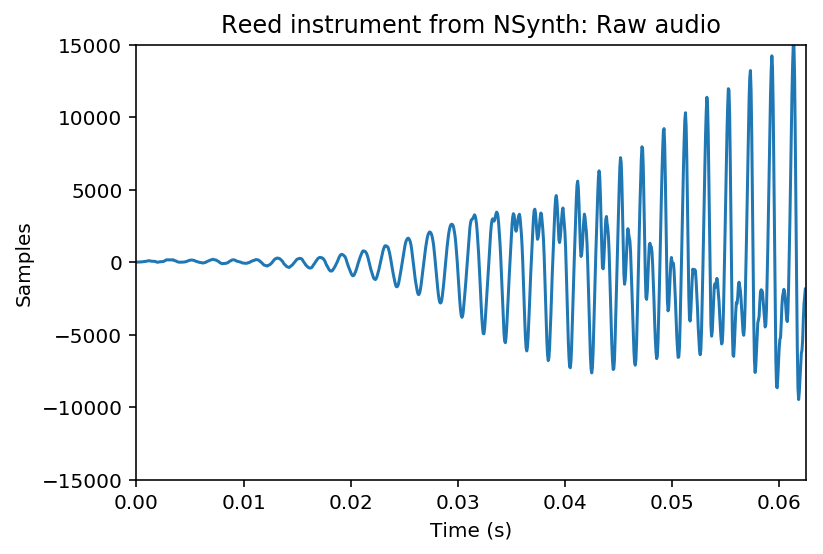

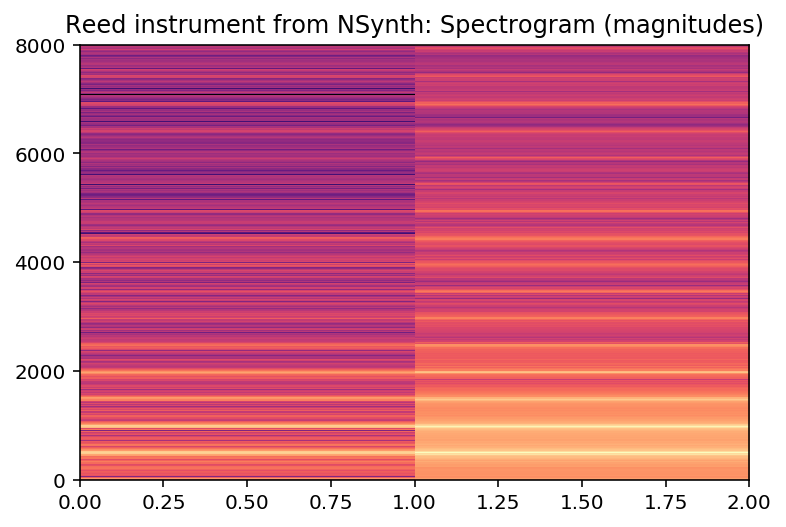

In [9]:
audioFigs('title-reed-instrument-scaled', 'Reed instrument from NSynth', audio[0:1000], 16000, 0.05, playBack=False)

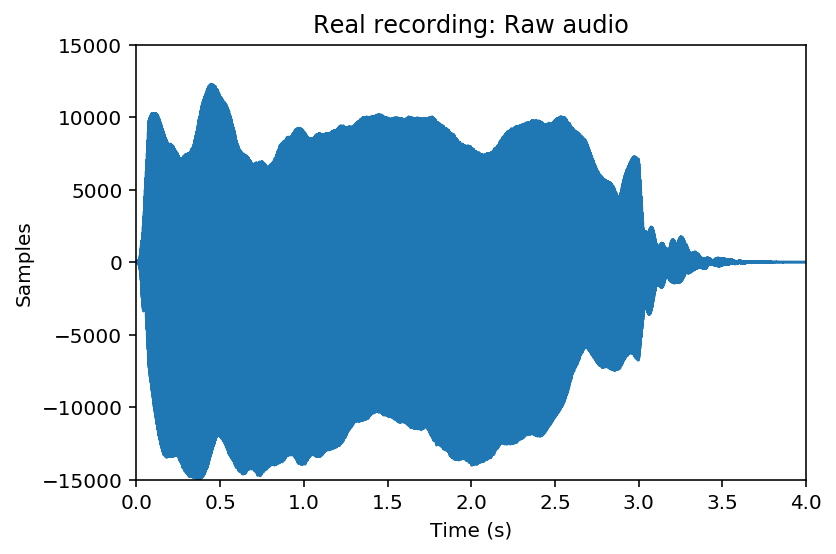

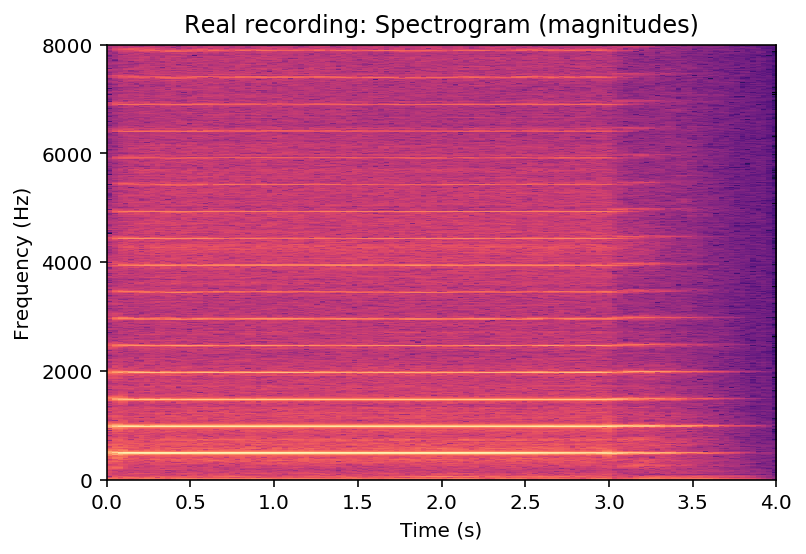

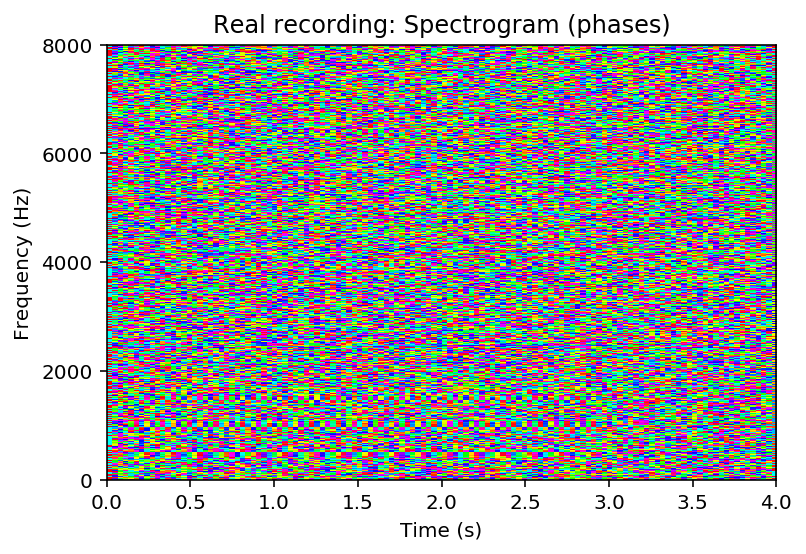

In [5]:
audioFigs('reed-instrument', None, audio, 16000, 0.5, playBack=False)

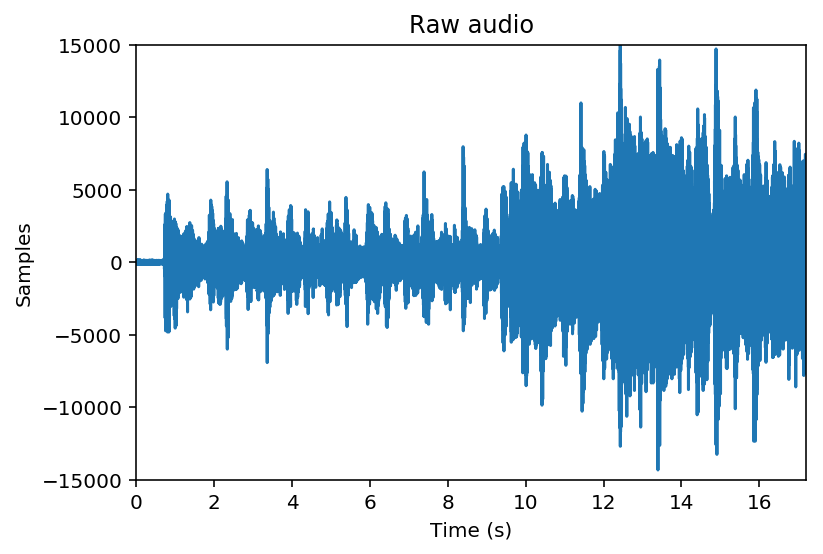

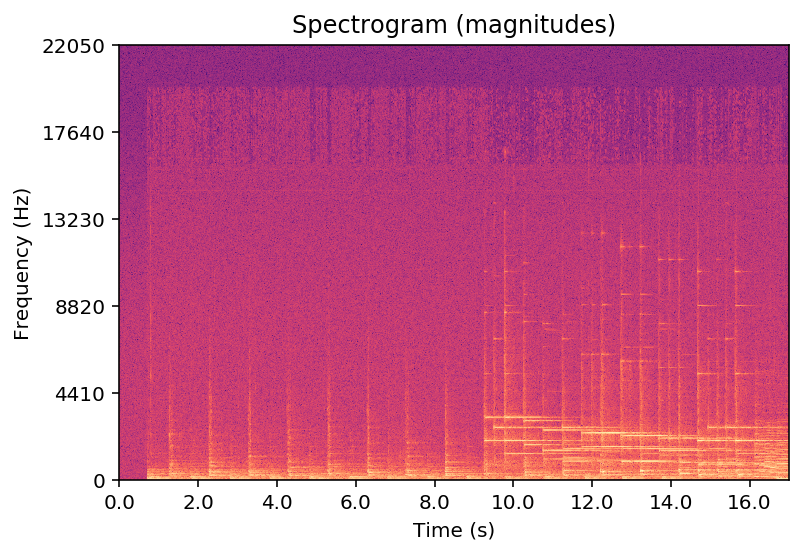

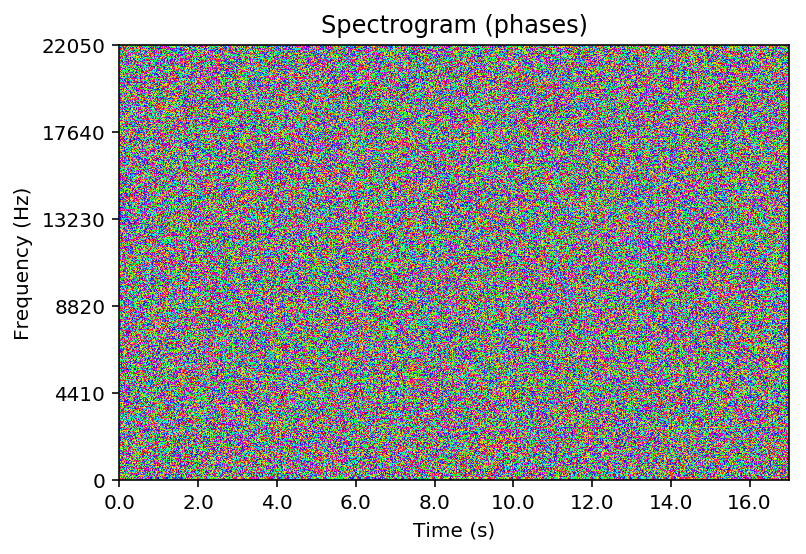

In [94]:
dance_sr, dance_audio = wavfile.read('real.wav')
audioFigs("dance", None, dance_audio, dance_sr, 2, playBack=False, seconds=17.2)

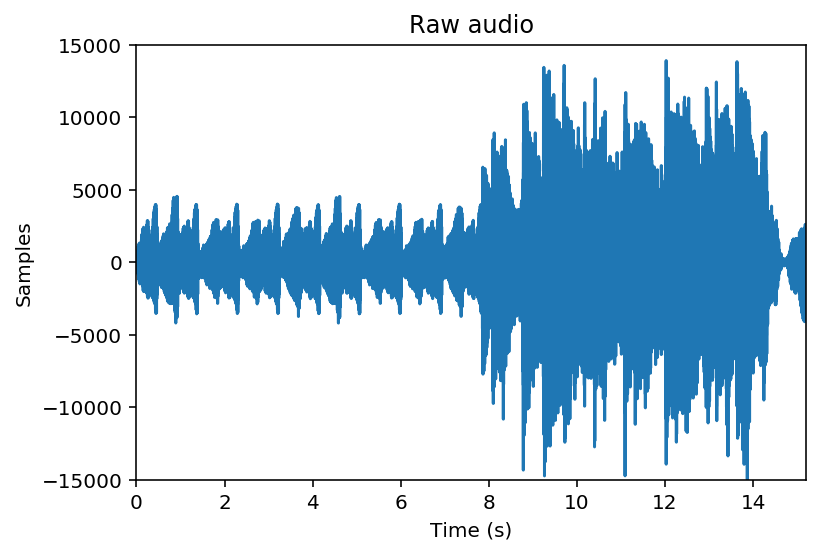

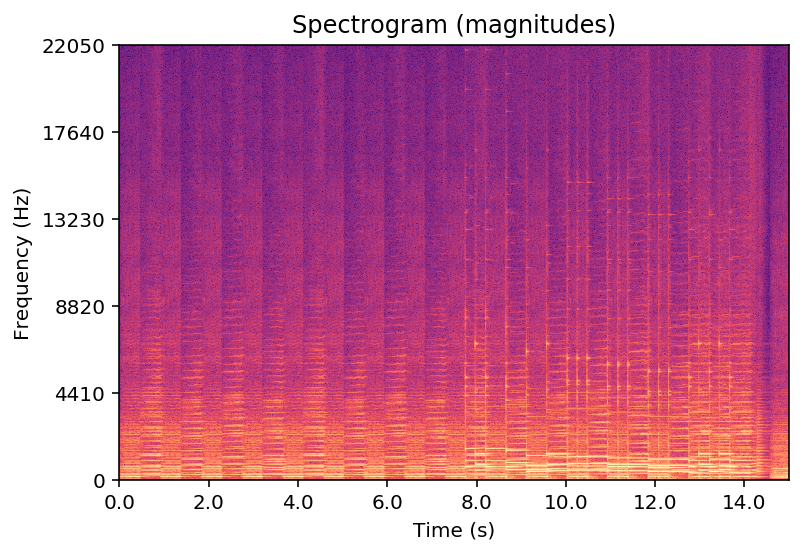

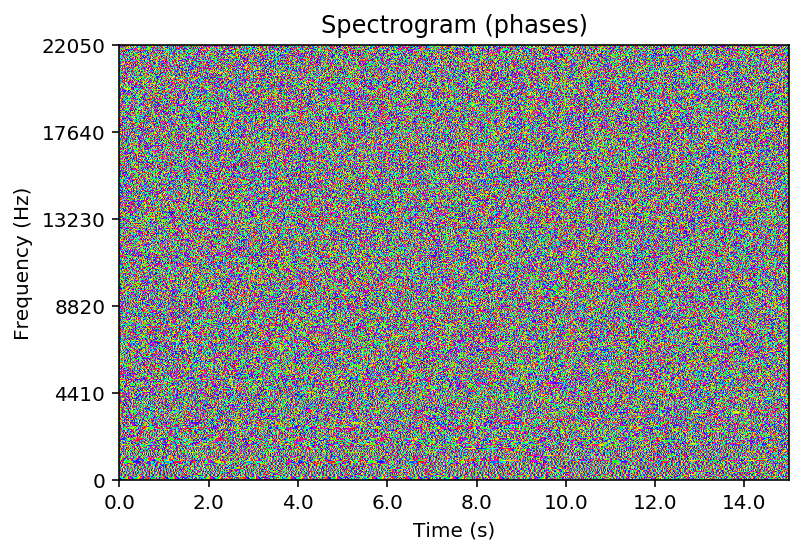

In [95]:
midi_audio, midi_sr = librosa.load('from-midi.wav', sr=None)
audioFigs("midi", None, midi_audio, midi_sr, 2, playBack=False, seconds=15.2)

In [42]:
playAudio(audio, 16000)

spectrogram = librosa.stft(audio)
magnitudes = np.log(np.abs(spectrogram) + 1.2664166e-14)
phases = np.angle(spectrogram) / math.pi

original_magnitudes = np.exp(magnitudes) - 1.2664166e-14
magonly_audio = librosa.istft(original_magnitudes)
playAudio(magonly_audio, 16000)
wavfile.write("no-phases-reed.wav", 16000, magonly_audio.astype(np.int16))

original_phases = phases * math.pi
original_spec = original_magnitudes*np.exp(original_phases*1j)
original_audio = librosa.istft(original_spec)
playAudio(original_audio, 16000)

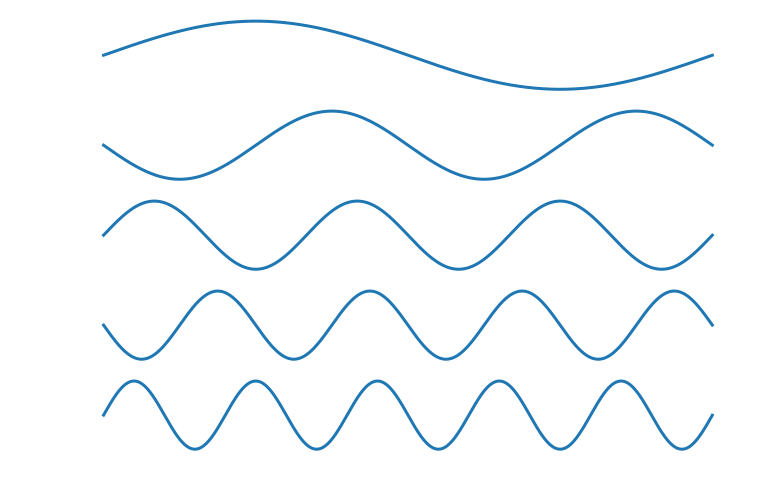

In [11]:
numplots = 5
fig, axes = plt.subplots(numplots, 1, sharex=True)
freq = 1
x = np.arange(0, 1, 0.0001)
y = []
for i in range(0, numplots):
    y.append(1/2 - np.power(-1, i+1)*np.sin(2*np.pi*(i+1)*freq*x)/(i+1)/np.pi)
    axes[i].plot(x, y[i])
    axes[i].axis('off')
plt.savefig("sawtooth-components.png", transparent=True)

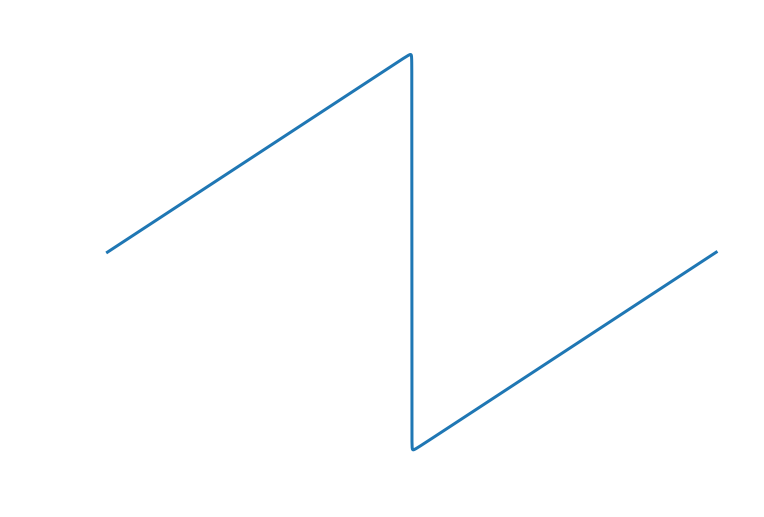

In [14]:
y = []
for i in range(0, 10000):
    y.append(1/2 - np.power(-1, i+1)*np.sin(2*np.pi*(i+1)*freq*x)/(i+1)/np.pi)
y_tot = np.sum(y, 0)
plt.plot(x, y_tot)
plt.axis('off')
plt.savefig('sawtooth-10000.png', transparent=True)

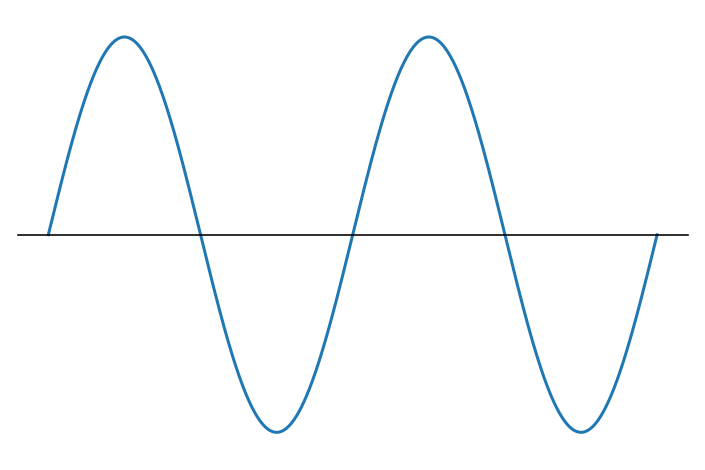

In [24]:
fig,ax = plt.subplots(1)
ax.plot(x, np.sin(2*np.pi*x*2))
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xticks([])
ax.set_yticks([])
fig.savefig('sine.png', transparent=True)

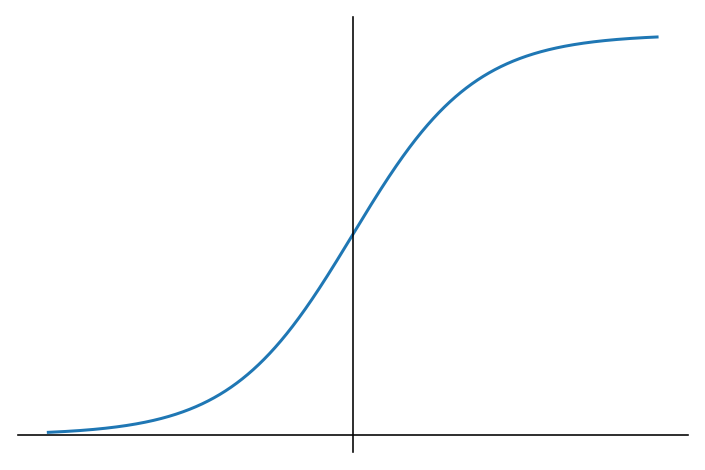

In [38]:
x = np.arange(-5, 5, 0.0001)
def sigmoid(x):
    ans = np.copy(x)
    for i in range(len(x)):
        ans[i] = 1 / (1 + math.exp(-ans[i]))
    return ans
fig,ax = plt.subplots(1)
ax.plot(x, sigmoid(x))
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
#ax.spines['left'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xticks([])
ax.set_yticks([])
fig.savefig('sigmoid.png', transparent=True)

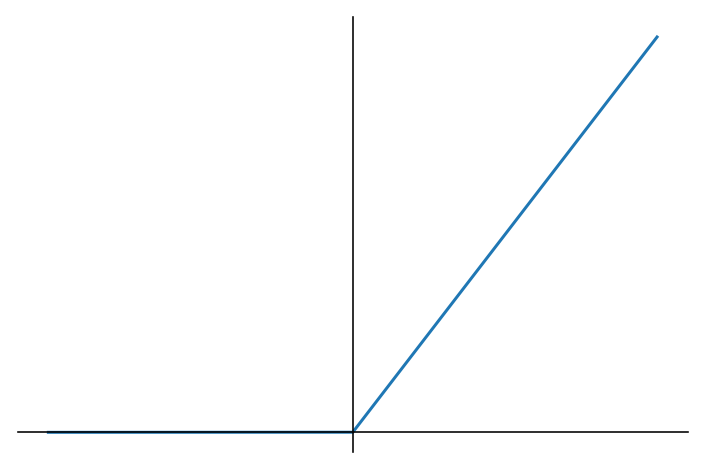

In [39]:
x = np.arange(-5, 5, 0.0001)
def relu(x):
    ans = np.copy(x)
    for i in range(len(x)):
        ans[i] = max(0,ans[i])
    return ans
fig,ax = plt.subplots(1)
ax.plot(x, relu(x))
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
#ax.spines['left'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xticks([])
ax.set_yticks([])
fig.savefig('relu.png', transparent=True)

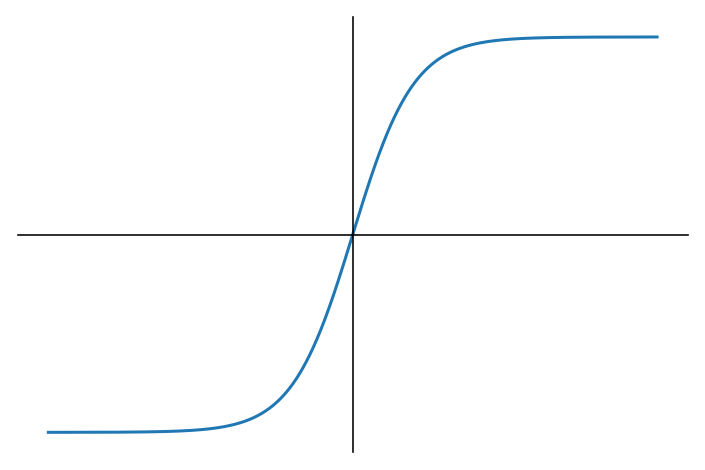

In [40]:
x = np.arange(-5, 5, 0.0001)
def relu(x):
    ans = np.copy(x)
    for i in range(len(x)):
        ans[i] = max(0,ans[i])
    return ans
fig,ax = plt.subplots(1)
ax.plot(x, np.tanh(x))
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
#ax.spines['left'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xticks([])
ax.set_yticks([])
fig.savefig('tanh.png', transparent=True)